## Assignment - Customer Churn

Treselle Systems, a data consulting service, analyzed customer churn data using logistic regression. For simply modeling whether or not a customer left this can work, but if we want to model the actual tenure of a customer, survival analysis is more appropriate.

The "tenure" feature represents the duration that a given customer has been with them, and "churn" represents whether or not that customer left (i.e. the "event", from a survival analysis perspective). So, any situation where churn is "no" means that a customer is still active, and so from a survival analysis perspective the observation is censored (we have their tenure up to now, but we don't know their true duration until event).

Your assignment is to use their data to fit a survival model, and answer the following questions:

    What features best model customer churn?
    What would you characterize as the "warning signs" that a customer may discontinue service?
    What actions would you recommend to this business to try to improve their customer retention?

Please create at least 3 plots or visualizations to support your findings, and in general write your summary/results targeting an "interested layperson" (e.g. your hypothetical business manager) as your audience.

This means that, as is often the case in data science, there isn't a single objective right answer - your goal is to support your answer, whatever it is, with data and reasoning.

Good luck!

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lifelines

In [6]:
# Loading the data to get you started
churn_data = pd.read_csv(
    'https://raw.githubusercontent.com/treselle-systems/'
    'customer_churn_analysis/master/WA_Fn-UseC_-Telco-Customer-Churn.csv')
churn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
churn_data.info()  # A lot of these are "object" - some may need to be fixed...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [14]:
type(churn_data["SeniorCitizen"][0])

numpy.int64

In [17]:
churn_data = churn_data.replace("Yes",1)
churn_data =churn_data.replace("No",0)

In [23]:
churn_data["Number_lines"] = churn_data["MultipleLines"].apply(lambda x : 0 if type(x)==str else x+1)

In [24]:
churn_data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Number_lines
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,...,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,0,0,34,1,0,DSL,1,...,0,0,0,One year,0,Mailed check,56.95,1889.5,0,1
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,1
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,1,...,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,0
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,1
5,9305-CDSKC,Female,0,0,0,8,1,1,Fiber optic,0,...,0,1,1,Month-to-month,1,Electronic check,99.65,820.5,1,2
6,1452-KIOVK,Male,0,0,1,22,1,1,Fiber optic,0,...,0,1,0,Month-to-month,1,Credit card (automatic),89.10,1949.4,0,2
7,6713-OKOMC,Female,0,0,0,10,0,No phone service,DSL,1,...,0,0,0,Month-to-month,0,Mailed check,29.75,301.9,0,0
8,7892-POOKP,Female,0,1,0,28,1,1,Fiber optic,0,...,1,1,1,Month-to-month,1,Electronic check,104.80,3046.05,1,2
9,6388-TABGU,Male,0,0,1,62,1,0,DSL,1,...,0,0,0,One year,0,Bank transfer (automatic),56.15,3487.95,0,1


In [27]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(churn_data["tenure"], event_observed=churn_data["Churn"])

0    0.5
dtype: float64


<lifelines.KaplanMeierFitter: fitted with 7043 observations, 5174 censored>

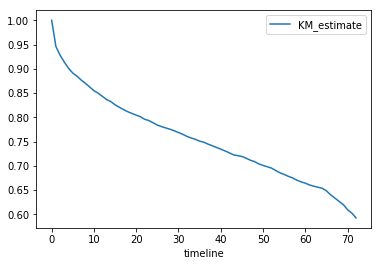

In [30]:
kmf.survival_function_.plot()

In [34]:
churn_data["Contract"].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [35]:
churn_data["Contract"] = churn_data["Contract"].replace('Month-to-month',0)
churn_data["Contract"] = churn_data["Contract"].replace('One year',1)
churn_data["Contract"] = churn_data["Contract"].replace('Two year',2)


In [40]:
time= churn_data["tenure"]
churn = churn_data["Churn"]

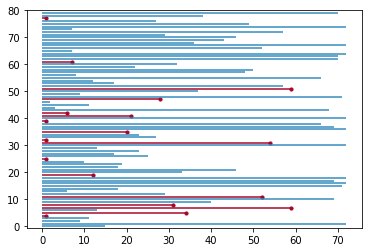

In [81]:
churn_sample = churn_data.sample(n=80)
time_s = churn_sample.tenure.values
churn_s = churn_sample.Churn.values
ax = lifelines.plotting.plot_lifetimes(time_s, event_observed=churn_s)

## Cox Proportional Hazards Model

In [84]:
churn_data["tenure"].max()

72

In [91]:
cph_data = churn_data[["SeniorCitizen","Partner","Dependents","PhoneService","Nu","tenure","Churn"]]

In [92]:
cph = lifelines.CoxPHFitter()
cph.fit(cph_data,  "tenure", "Churn")

<lifelines.CoxPHFitter: fitted with 7043 observations, 5174 censored>

### Contract length

In [36]:
contract = churn_data["Contract"]

In [38]:
month_to_month = (churn_data["Contract"] == 0)
one_year = (churn_data["Contract"]==1)
two_year = (churn_data["Contract"]==2)

0    0.5
dtype: float64
Median Tenure with month-to-month contract: 35.0 months
0    0.5
dtype: float64
Median Tenure with one-year contract: inf months
0    0.5
dtype: float64
Median Tenure with two-year contract: inf months


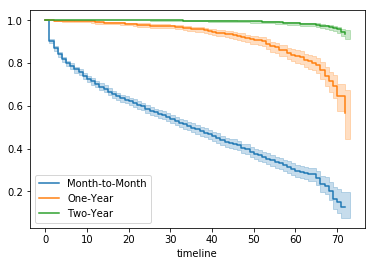

In [56]:
ax = plt.subplot(111)

kmf.fit(time[month_to_month], event_observed =churn[month_to_month], label = "Month-to-Month" )
kmf.plot(ax=ax)
print(f'Median Tenure with month-to-month contract: {kmf.median_} months')

kmf.fit(time[one_year], event_observed =churn[one_year], label = "One-Year")
kmf.plot(ax=ax)
print(f'Median Tenure with one-year contract: {kmf.median_} months')
kmf.fit(time[two_year], event_observed =churn[two_year], label = "Two-Year" )
kmf.plot(ax=ax)
print(f'Median Tenure with two-year contract: {kmf.median_} months')

### Gender

0    0.5
dtype: float64
Median Tenure for males: inf months
0    0.5
dtype: float64
Median Tenure for females: inf months


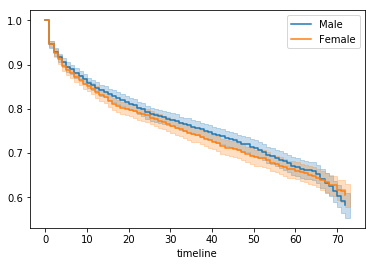

In [54]:
male = (churn_data["gender"] == "Male")
female = (churn_data["gender"]== "Female")

ax = plt.subplot(111)

kmf.fit(time[male], event_observed =churn[male], label = "Male" )
kmf.plot(ax=ax)
print(f'Median Tenure for males: {kmf.median_} months')

kmf.fit(time[female], event_observed =churn[female], label = "Female" )
kmf.plot(ax=ax)
print(f'Median Tenure for females: {kmf.median_} months')


### Internet Service

In [60]:
churn_data["InternetService"].unique()

array(['DSL', 'Fiber optic', 0], dtype=object)

In [61]:
o = (churn_data["InternetService"] == 0)
dsl = (churn_data["InternetService"] == "DSL")
fiber = (churn_data["InternetService"] == "Fiber optic")

0    0.5
dtype: float64
Median Tenure for internet category "0": inf months
0    0.5
dtype: float64
Median Tenure for DSL Internet: inf months
0    0.5
dtype: float64
Median Tenure for Fiber Optic Internet: 65.0 months


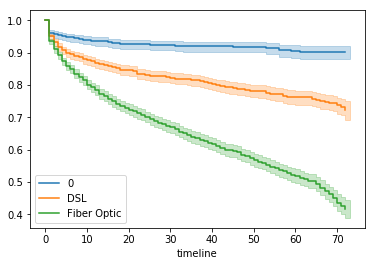

In [65]:
ax = plt.subplot(111)

kmf.fit(time[o], event_observed =churn[o], label = "0" )
kmf.plot(ax=ax)
print(f'Median Tenure for internet category "0": {kmf.median_} months')

kmf.fit(time[dsl], event_observed =churn[dsl], label = "DSL" )
kmf.plot(ax=ax)
print(f'Median Tenure for DSL Internet: {kmf.median_} months')

kmf.fit(time[fiber], event_observed =churn[fiber], label = "Fiber Optic" )
kmf.plot(ax=ax)
print(f'Median Tenure for Fiber Optic Internet: {kmf.median_} months')

### Senior Citizens

In [66]:
churn_data["SeniorCitizen"].unique()

array([0, 1], dtype=int64)

In [67]:
not_senior = (churn_data["SeniorCitizen"] == 0)
senior = (churn_data["SeniorCitizen"] == 1)

0    0.5
dtype: float64
Median Tenure for Non_seniors: inf months
0    0.5
dtype: float64
Median Tenure for Seniors: 65.0 months


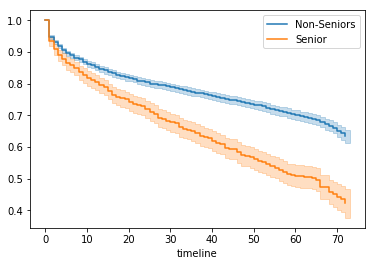

In [68]:
ax = plt.subplot(111)

kmf.fit(time[not_senior], event_observed =churn[not_senior], label = "Non-Seniors" )
kmf.plot(ax=ax)
print(f'Median Tenure for Non_seniors: {kmf.median_} months')

kmf.fit(time[senior], event_observed =churn[senior], label = "Senior" )
kmf.plot(ax=ax)
print(f'Median Tenure for Seniors: {kmf.median_} months')


### internet & month-to-month contract

In [70]:
df_m2m = churn_data[churn_data["Contract"]==0]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Number_lines
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,...,0,0,0,0,1,Electronic check,29.85,29.85,0,0
2,3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,...,0,0,0,0,1,Mailed check,53.85,108.15,1,1
4,9237-HQITU,Female,0,0,0,2,1,0,Fiber optic,0,...,0,0,0,0,1,Electronic check,70.70,151.65,1,1
5,9305-CDSKC,Female,0,0,0,8,1,1,Fiber optic,0,...,0,1,1,0,1,Electronic check,99.65,820.5,1,2
6,1452-KIOVK,Male,0,0,1,22,1,1,Fiber optic,0,...,0,1,0,0,1,Credit card (automatic),89.10,1949.4,0,2
7,6713-OKOMC,Female,0,0,0,10,0,No phone service,DSL,1,...,0,0,0,0,0,Mailed check,29.75,301.9,0,0
8,7892-POOKP,Female,0,1,0,28,1,1,Fiber optic,0,...,1,1,1,0,1,Electronic check,104.80,3046.05,1,2
10,9763-GRSKD,Male,0,1,1,13,1,0,DSL,1,...,0,0,0,0,1,Mailed check,49.95,587.45,0,1
13,0280-XJGEX,Male,0,0,0,49,1,1,Fiber optic,0,...,0,1,1,0,1,Bank transfer (automatic),103.70,5036.3,1,2
14,5129-JLPIS,Male,0,0,0,25,1,0,Fiber optic,1,...,1,1,1,0,1,Electronic check,105.50,2686.05,0,1


In [71]:
time_m2m= df_m2m["tenure"]
churn_m2m = df_m2m["Churn"]

In [72]:
o_m2m = (df_m2m["InternetService"] == 0)
dsl_m2m = (df_m2m["InternetService"] == "DSL")
fiber_m2m = (df_m2m["InternetService"] == "Fiber optic")

0    0.5
dtype: float64
Median Tenure for internet category "0": 61.0 months
0    0.5
dtype: float64
Median Tenure for DSL Internet: 52.0 months
0    0.5
dtype: float64
Median Tenure for Fiber Optic Internet: 30.0 months


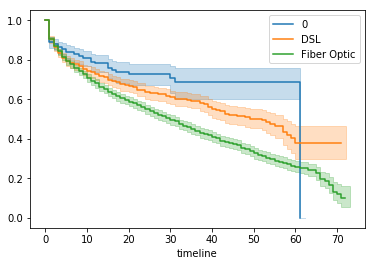

In [73]:
ax = plt.subplot(111)

kmf.fit(time_m2m[o_m2m], event_observed =churn_m2m[o_m2m], label = "0" )
kmf.plot(ax=ax)
print(f'Median Tenure for internet category "0": {kmf.median_} months')

kmf.fit(time_m2m[dsl_m2m], event_observed =churn_m2m[dsl_m2m], label = "DSL" )
kmf.plot(ax=ax)
print(f'Median Tenure for DSL Internet: {kmf.median_} months')

kmf.fit(time_m2m[fiber_m2m], event_observed =churn_m2m[fiber_m2m], label = "Fiber Optic" )
kmf.plot(ax=ax)
print(f'Median Tenure for Fiber Optic Internet: {kmf.median_} months')

# Analysis

### Contract Length
Month-to-Month contracts are a significant source of customer churn. The median tenure for a month-to-month contract customer is 35 months. None of these customers lasted over 70 months. Over half the customers who have entered into a 1-year contract are still with the company. Nearly all customer who enter a two-year contract are with the company.

### Internet Service
We do not lose many customers who do not use our internet service. We experience a significant amount of churn from our Fiber Optic customers.

# Recommendations
- We should create stronger incentives for switching to long-term contracts.
- We should examine our competitiveness in the fiber optic internet space.